In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/Sales-and-Marketing.csv
/kaggle/input/Tractor-Sales.csv


In [2]:
import pandas as pd
import numpy as np
import itertools
import calendar as cld
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

In [3]:
data1 = pd.read_csv("../input/Tractor-Sales.csv")

## Univariate Time series Analysis

In [4]:
data1.head()

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [5]:
# quick renaming columns
data1.columns = ['Date','Tractor_Sales']

In [6]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Date             144 non-null object
Tractor_Sales    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [7]:
data1['Date'] # date covered is from Jan2003 to Dec2014

0      Jan-03
1      Feb-03
2      Mar-03
3      Apr-03
4      May-03
        ...  
139    Aug-14
140    Sep-14
141    Oct-14
142    Nov-14
143    Dec-14
Name: Date, Length: 144, dtype: object

In [8]:
# creating date-time format dates from January 2003 till December 2014 [taking 1st of every month]
#dates = pd.date_range(start = '01-01-2003', freq='MS', end = '31-12-2014') # end date is right bound, hence giving 31-12-2014
#or
dates = pd.date_range(start = '01-01-2003', freq='MS', periods = 144) # period = 144 as there are 144 observations

In [9]:
dates

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

In [10]:
data1['Year'] = dates.year
data1['Month'] = dates.month
data1['Month'] = data1['Month'].apply(lambda m : cld.month_abbr[m])

In [11]:
# dropping the object type month-year column
data1.drop(columns=['Date'],inplace=True)

In [12]:
data1.head()

,Tractor_Sales,Year,Month
0,141,2003,Jan
1,157,2003,Feb
2,185,2003,Mar
3,199,2003,Apr
4,203,2003,May


In [13]:
# indexing the data by dates for time series analysis
data1.set_index(dates, inplace=True)

In [14]:
data1  #indexed date is 1st of everymonth from 2003 to 2014

,Tractor_Sales,Year,Month
2003-01-01,141,2003,Jan
2003-02-01,157,2003,Feb
2003-03-01,185,2003,Mar
2003-04-01,199,2003,Apr
2003-05-01,203,2003,May
...,...,...,...
2014-08-01,848,2014,Aug
2014-09-01,640,2014,Sep
2014-10-01,581,2014,Oct
2014-11-01,519,2014,Nov


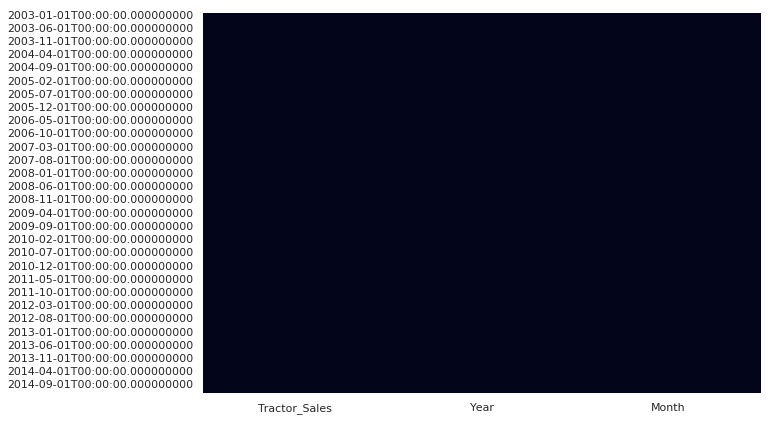

In [15]:
# checking for any nulls
sns.set(style='whitegrid')
plt.figure(figsize=(10,7))
sns.heatmap(data1.isnull(), cbar=False)  #no nulls as per heatmap

In [16]:
trac_sales = data1['Tractor_Sales']
trac_sales.head()

2003-01-01    141
2003-02-01    157
2003-03-01    185
2003-04-01    199
2003-05-01    203
Freq: MS, Name: Tractor_Sales, dtype: int64

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Sales')

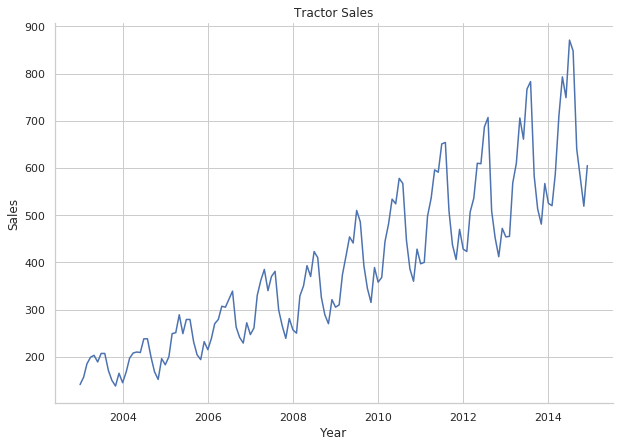

In [17]:
plt.figure(figsize=(10,7))
plt.title('Tractor Sales')
sns.lineplot(data=trac_sales)
sns.despine(top=True, right=True)
plt.xlabel('Year')
plt.ylabel('Sales')

**INFERENCE FROM ABOVE PLOT**

* we can see an overall trend in tractor sales - which is an increasing trend
* the plot also explains that there is seasonality present, as the the pattern/shape of plot repeats evry year
* however we don't see any cyclic pattern
* from the plot we also conclude that the data is not stationary

## Decomposition of data

### Manual Decomposition

In [18]:
# taking different window rolling avergaes 
ma4 = trac_sales.rolling(window=4).mean()
ma6 = trac_sales.rolling(window=6).mean()
ma10 = trac_sales.rolling(window=10).mean()
ma12 = trac_sales.rolling(window=12).mean()

Text(0.5, 0.98, 'Rolling Avergaes Plots')

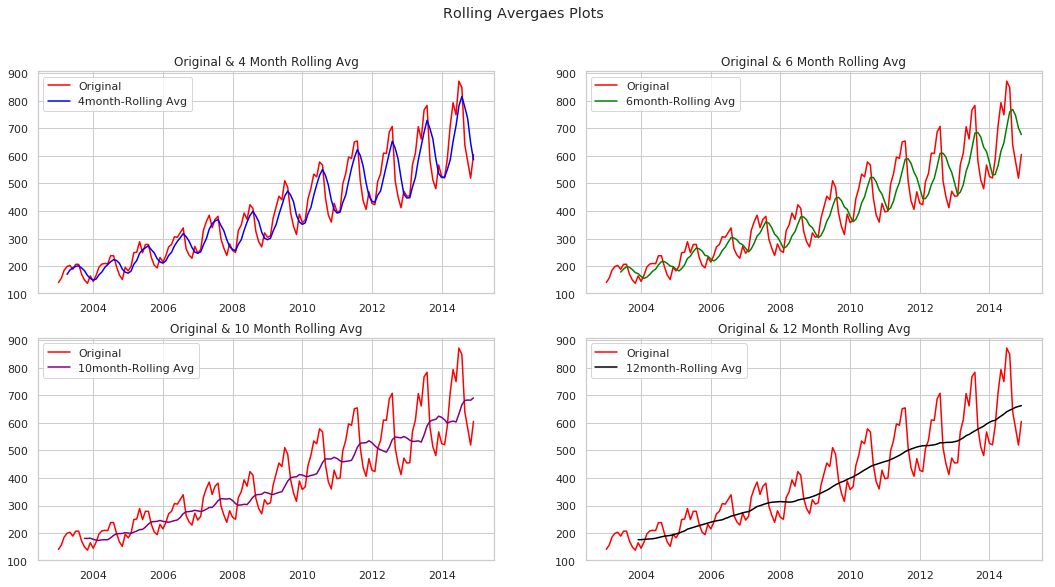

In [19]:
f,ax=plt.subplots(2,2,figsize=(18,9))

#original & 4month rolling avg
sns.lineplot(data=trac_sales, color='red', label='Original', ax=ax[0,0])
sns.lineplot(data=ma4, color='blue', label ='4month-Rolling Avg', ax=ax[0,0])
ax[0,0].set_title('Original & 4 Month Rolling Avg')

#original & 6month avg
sns.lineplot(data=trac_sales, color='red', label='Original', ax=ax[0,1])
sns.lineplot(data=ma6, color='green', label='6month-Rolling Avg', ax=ax[0,1])
ax[0,1].set_title('Original & 6 Month Rolling Avg')

#original & 10month avg
sns.lineplot(data=trac_sales, color='red', label='Original', ax=ax[1,0])
sns.lineplot(data=ma10, color='purple', label='10month-Rolling Avg', ax=ax[1,0])
ax[1,0].set_title('Original & 10 Month Rolling Avg')

#original & 12month avg
sns.lineplot(data=trac_sales, color='red', label='Original', ax=ax[1,1])
sns.lineplot(data=ma12, color='black', label='12month-Rolling Avg', ax=ax[1,1])
ax[1,1].set_title('Original & 12 Month Rolling Avg')

plt.suptitle('Rolling Avergaes Plots')

**INFERENCE FROM ABOVE PLOTS**
* from above plots we can clearly see that the line for 12Month-Rolling average is very smooth.
* hence we can conclude that our data has monthly seasonality, meaning there is monthly pattern present in our data.

### SEASONALITY
**Understanding Seasonality**
* seasonality is any pattern, variation that occurs at specific regular intervals less than a year
* seasonality may occur daily, weekly, quarterly or half yearly.
* eg : every year in June, there is peak in sales and every year in December there is slump in sales, such pattern within 1 periodic year is said to be seasonality.

In [20]:
df2 = pd.pivot_table(data=data1, index='Month', columns='Year', values='Tractor_Sales')
df2 = df2.reindex (index =['Jan','Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
df2

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Mar,185,197,249,270,330,329,374,444,498,507,568,587
Apr,199,208,251,279,362,350,414,482,536,536,610,710
May,203,210,289,307,385,393,454,534,596,610,706,793
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Sep,171,199,232,263,299,326,393,447,509,509,583,640


In [21]:
df3 = pd.pivot_table(data=data1, columns='Month', index='Year', values='Tractor_Sales')
df3 = df3[['Jan','Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
df3

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2003,141,157,185,199,203,189,207,207,171,150,138,165
2004,145,168,197,208,210,209,238,238,199,168,152,196
2005,183,200,249,251,289,249,279,279,232,204,194,232
2006,215,239,270,279,307,305,322,339,263,241,229,272
2007,247,261,330,362,385,340,370,381,299,266,239,281
2008,257,250,329,350,393,370,423,410,326,289,270,321
2009,305,310,374,414,454,441,510,486,393,345,315,389
2010,358,368,444,482,534,524,578,567,447,386,360,428
2011,397,400,498,536,596,591,651,654,509,437,406,470


Text(0.5, 0.98, 'Plots describing Seasonality')

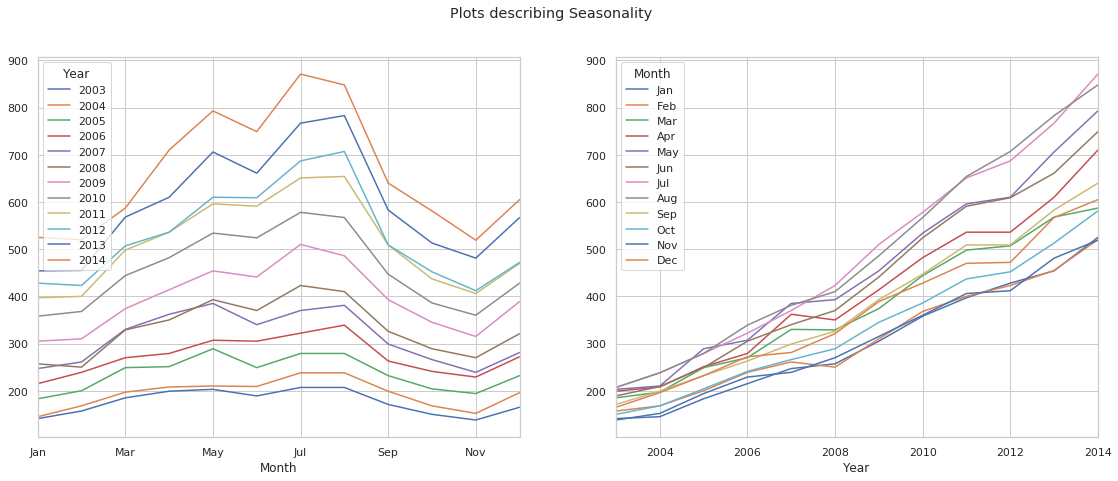

In [22]:
f,ax=plt.subplots(1,2, figsize=(19,7))
df2.plot(ax=ax[0])
df3.plot(ax=ax[1])
plt.suptitle('Plots describing Seasonality')

**INFERENCES FROM ABOVE PLOT**
* from the first plot it is clearly visible that monthly pattern is present year after year
* we can see in the first plot that, sales in low in Jan of every year, then starts to increase, then dips in June, then peaks at July every year.

* from the second plot also we conclude the same, sales in january is low every year, while those of july and august are peak every year
* Another important inference from both plots is that the overall tractor sales also has been increasing year after year

### Statsmodels Decompose

In [23]:
decomposed1 = sm.tsa.seasonal_decompose(trac_sales, model='multiplicative', two_sided=False, extrapolate_trend=4)

In [24]:
# seasonal component
decomposed1.seasonal

2003-01-01    0.823508
2003-02-01    0.853891
2003-03-01    1.024830
2003-04-01    1.092962
2003-05-01    1.187805
                ...   
2014-08-01    1.222687
2014-09-01    0.950868
2014-10-01    0.829943
2014-11-01    0.760143
2014-12-01    0.898956
Freq: MS, Name: Tractor_Sales, Length: 144, dtype: float64

In [25]:
# trend component
decomposed1.trend

2003-01-01    166.408333
2003-02-01    167.216667
2003-03-01    168.025000
2003-04-01    168.833333
2003-05-01    169.641667
                 ...    
2014-08-01    642.875000
2014-09-01    647.958333
2014-10-01    653.166667
2014-11-01    657.583333
2014-12-01    660.750000
Freq: MS, Name: Tractor_Sales, Length: 144, dtype: float64

In [26]:
# residual component
decomposed1.resid

2003-01-01    1.028907
2003-02-01    1.099557
2003-03-01    1.074350
2003-04-01    1.078424
2003-05-01    1.007438
                ...   
2014-08-01    1.078833
2014-09-01    1.038754
2014-10-01    1.071776
2014-11-01    1.038297
2014-12-01    1.018544
Freq: MS, Name: Tractor_Sales, Length: 144, dtype: float64

Text(0.5, 0.98, 'Time Series Decomposition')

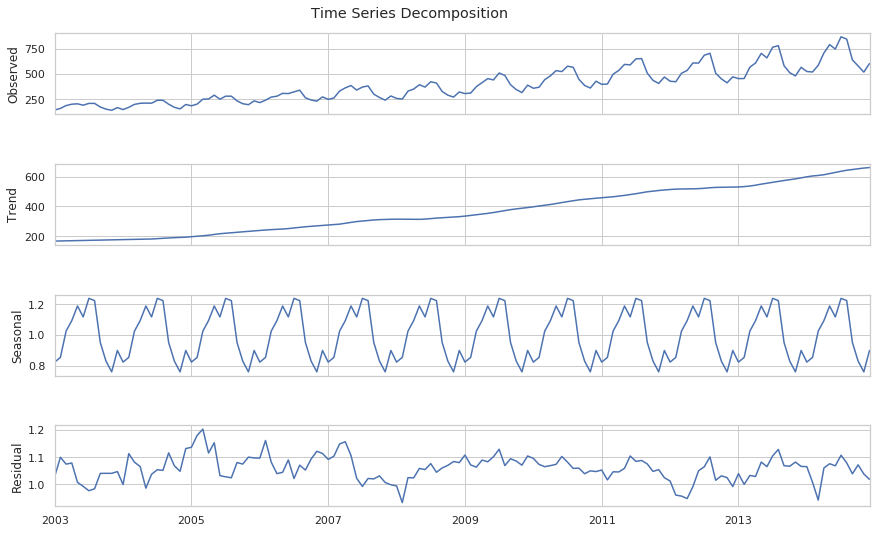

In [27]:
fig = decomposed1.plot()
fig.set_figwidth(14)
fig.set_figheight(8)
fig.suptitle('Time Series Decomposition')

In [28]:
decomposed1_df = pd.concat([decomposed1.observed,decomposed1.trend, decomposed1.seasonal, decomposed1.resid],axis=1)
decomposed1_df.columns = ['Observed','Trend','Seasonal','Irregular']
decomposed1_df

,Observed,Trend,Seasonal,Irregular
2003-01-01,141,166.408333,0.823508,1.028907
2003-02-01,157,167.216667,0.853891,1.099557
2003-03-01,185,168.025000,1.024830,1.074350
2003-04-01,199,168.833333,1.092962,1.078424
2003-05-01,203,169.641667,1.187805,1.007438
...,...,...,...,...
2014-08-01,848,642.875000,1.222687,1.078833
2014-09-01,640,647.958333,0.950868,1.038754
2014-10-01,581,653.166667,0.829943,1.071776
2014-11-01,519,657.583333,0.760143,1.038297


In [29]:
decomposed1_df['Multiplied'] = decomposed1_df.Trend*decomposed1_df.Seasonal*decomposed1_df.Irregular
decomposed1_df

,Observed,Trend,Seasonal,Irregular,Multiplied
2003-01-01,141,166.408333,0.823508,1.028907,141.0
2003-02-01,157,167.216667,0.853891,1.099557,157.0
2003-03-01,185,168.025000,1.024830,1.074350,185.0
2003-04-01,199,168.833333,1.092962,1.078424,199.0
2003-05-01,203,169.641667,1.187805,1.007438,203.0
...,...,...,...,...,...
2014-08-01,848,642.875000,1.222687,1.078833,848.0
2014-09-01,640,647.958333,0.950868,1.038754,640.0
2014-10-01,581,653.166667,0.829943,1.071776,581.0
2014-11-01,519,657.583333,0.760143,1.038297,519.0


performing ADF test for time series data to check stationary or not
* H0 : series not stationary
* H1 : series is staionary

In [30]:
smt.stattools.adfuller(trac_sales)

(1.1088250591467337,
 0.9952912415248419,
 14,
 129,
 {'1%': -3.482087964046026,
  '5%': -2.8842185101614626,
  '10%': -2.578864381347275},
 1082.5357724796872)

since p-value > alpha(0.05) hence null accepted, i.e. series is NOT stationary

In [31]:
# time series data can be made stationary through combination of log and differences

trac_sales2 = (np.log10(trac_sales)).diff(2)  # taking log10 and then creating double lag
trac_sales2

2003-01-01         NaN
2003-02-01         NaN
2003-03-01    0.117953
2003-04-01    0.102953
2003-05-01    0.040324
                ...   
2014-08-01    0.053914
2014-09-01   -0.133838
2014-10-01   -0.164220
2014-11-01   -0.091013
2014-12-01    0.017579
Freq: MS, Name: Tractor_Sales, Length: 144, dtype: float64

In [32]:
trac_sales2.dropna(inplace=True)
smt.adfuller(trac_sales2)

(-3.2007215662324073,
 0.019942950105461026,
 11,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 -646.748135238141)

from above result :
* since the p-value(0.019) < alpha (0.05), we reject H0
* hence we may conlcude that the new time series trac_sales2 which has been log transformed and differenced(lag) twice is staionary series

Text(0.5, 1.0, 'Tractor Sales _ New Stationary Data')

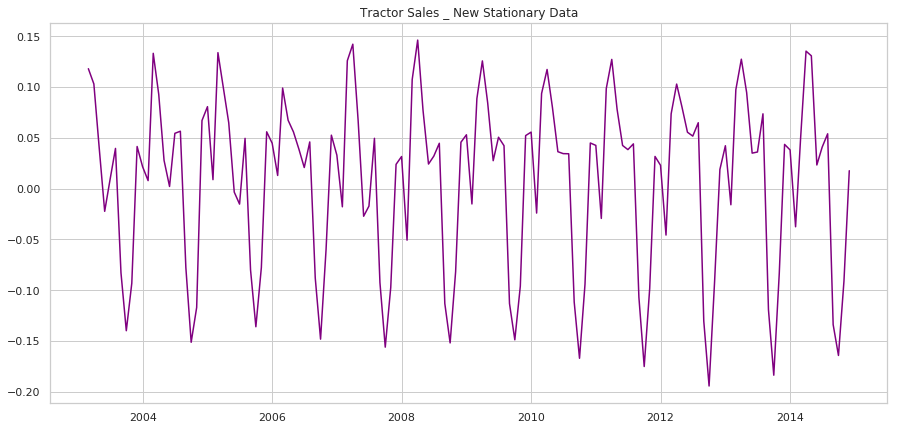

In [33]:
plt.figure(figsize=(15,7))
sns.lineplot(data=trac_sales2,color='purple')
plt.title('Tractor Sales _ New Stationary Data')

## SARIMA Modelling

#### finding optimum values of p,d,q ; we already know d=2, from ADF test

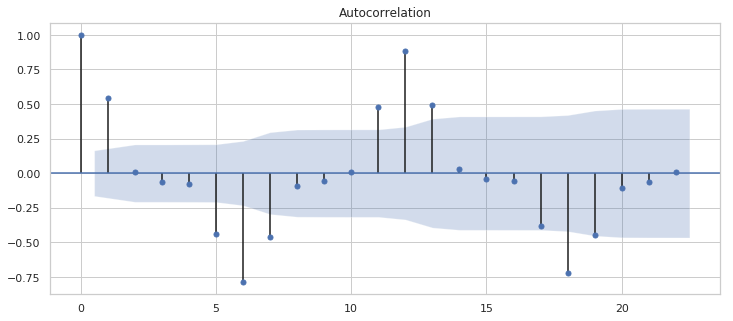

In [34]:
# plotting Auto-correlation function to find optimum "p" value for ARIMA
fig2 = smt.graphics.plot_acf(trac_sales2)
fig2.set_figwidth(12)
fig2.set_figheight(5)
fig2.show()

From the above ACF plot it is clear that p=1 (since ACF becomes zero after 1st lag)

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


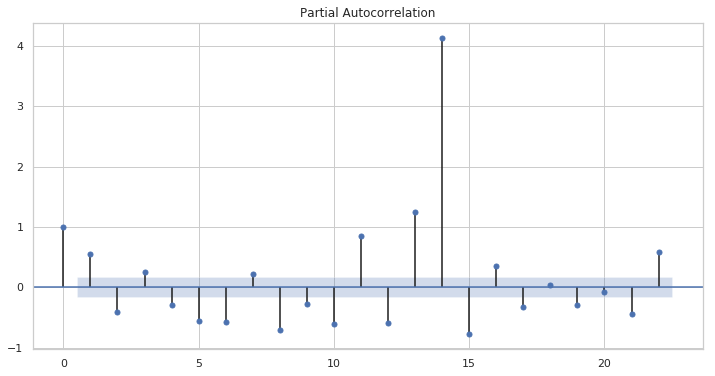

In [35]:
# plotting Partial Auto Correlation Function(PACF) to find best "q"
fig3 = smt.graphics.plot_pacf(trac_sales2)
fig3.set_figheight(6)
fig3.set_figwidth(12)

from above PACF plot it is clear that value of "q" = 1

In [36]:
# as our data contains seasonality, we need to find P,D,Q too
# we'll do that by finding AIC (Akaike Information Criterion)

p = q = range(0, 3) # we know p and q were 1, still taking range [0-2] to find best one
d = range(2,3)  # we know d=2
pdq = list(itertools.product(p, d, q))
pdq

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [37]:
# for finding best PDQ (Seasonal ARIMA parameters)
D = range(0,2)  # 
P = Q = range(0, 2) 
spdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]  # 12 is for seasonality
spdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [38]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in spdq:
        
        try:
            temp_model = smt.statespace.SARIMAX(np.log10(trac_sales),
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

Best SARIMAX(1, 2, 1)x(1, 0, 1, 12)12 model - AIC:-673.293362999297


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [39]:
model = smt.statespace.SARIMAX(np.log10(trac_sales), order=(1,2,1), seasonal_order=(1,0,1,12), enforce_stationarity=False, enforce_invertibility=False)

In [40]:
sari = model.fit()

In [41]:
print(sari.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      Tractor_Sales   No. Observations:                  144
Model:             SARIMAX(1, 2, 1)x(1, 0, 1, 12)   Log Likelihood                 341.647
Date:                            Fri, 06 Dec 2019   AIC                           -673.293
Time:                                    19:40:50   BIC                           -659.033
Sample:                                01-01-2003   HQIC                          -667.499
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3570      0.073     -4.891      0.000      -0.500      -0.214
ma.L1         -0.9999     11.342   

In [42]:
predicted_2014 = sari.get_prediction(start = pd.to_datetime('2014-01-01'))
pred_sales_2014 = predicted_2014.predicted_mean

In [43]:
pred_sales_2014

2014-01-01    2.723845
2014-02-01    2.723634
2014-03-01    2.809682
2014-04-01    2.812615
2014-05-01    2.888880
2014-06-01    2.885715
2014-07-01    2.933836
2014-08-01    2.942476
2014-09-01    2.808329
2014-10-01    2.747031
2014-11-01    2.725427
2014-12-01    2.790536
Freq: MS, dtype: float64

In [44]:
pred_sales_2014 = np.power(10,pred_sales_2014)
pred_sales_2014

2014-01-01    529.473973
2014-02-01    529.217611
2014-03-01    645.182323
2014-04-01    649.554343
2014-05-01    774.247950
2014-06-01    768.625907
2014-07-01    858.689853
2014-08-01    875.942402
2014-09-01    643.174949
2014-10-01    558.509817
2014-11-01    531.406757
2014-12-01    617.356687
Freq: MS, dtype: float64

In [45]:
sales_2014 = trac_sales['01-01-2014':]
sales_2014

2014-01-01    525
2014-02-01    520
2014-03-01    587
2014-04-01    710
2014-05-01    793
2014-06-01    749
2014-07-01    871
2014-08-01    848
2014-09-01    640
2014-10-01    581
2014-11-01    519
2014-12-01    605
Freq: MS, Name: Tractor_Sales, dtype: int64

In [46]:
print('mean absolute error :',metrics.mean_absolute_error(sales_2014, pred_sales_2014))
print('mean squarred error :',metrics.mean_squared_error(sales_2014, pred_sales_2014))

mean absolute error : 21.781553890154793
mean squarred error : 802.956506857157


## Forecasting for future period

#### Forecasting for a period of 48 months / 4 years

In [47]:
prd = 48
forecast_48 = sari.get_forecast(prd, alpha=0.05) # alpha = 0.05 for 95% confidence

In [48]:
intervals = forecast_48.conf_int()

In [49]:
intervals.head(10)

,lower Tractor_Sales,upper Tractor_Sales
2015-01-01,2.719994,2.783555
2015-02-01,2.712332,2.788241
2015-03-01,2.779811,2.870707
2015-04-01,2.827608,2.930205
2015-05-01,2.874911,2.988634
2015-06-01,2.849301,2.973185
2015-07-01,2.905245,3.038731
2015-08-01,2.898563,3.041141
2015-09-01,2.768701,2.919976
2015-10-01,2.713227,2.872860


In [50]:
date_index = pd.date_range(trac_sales.index[-1], periods=prd, freq='MS')

forecast_48_df = pd.DataFrame(np.column_stack([np.power(10, forecast_48.predicted_mean), np.power(10, intervals)]), 
                     index=date_index, columns=['Forecast', 'Lower_Forecast', 'Upper_Forecast'])
forecast_48_df

,Forecast,Lower_Forecast,Upper_Forecast
2014-12-01,564.643182,524.799761,607.511562
2015-01-01,562.712265,515.622947,614.102019
2015-02-01,668.742922,602.297715,742.518334
2015-03-01,756.669604,672.369201,851.539435
2015-04-01,854.619113,749.741139,974.168004
2015-05-01,815.160346,706.807156,940.124025
2015-06-01,937.535837,803.979710,1093.278145
2015-07-01,932.936644,791.704359,1099.363382
2015-08-01,698.776358,587.084702,831.717122
2015-09-01,620.930684,516.685851,746.207611


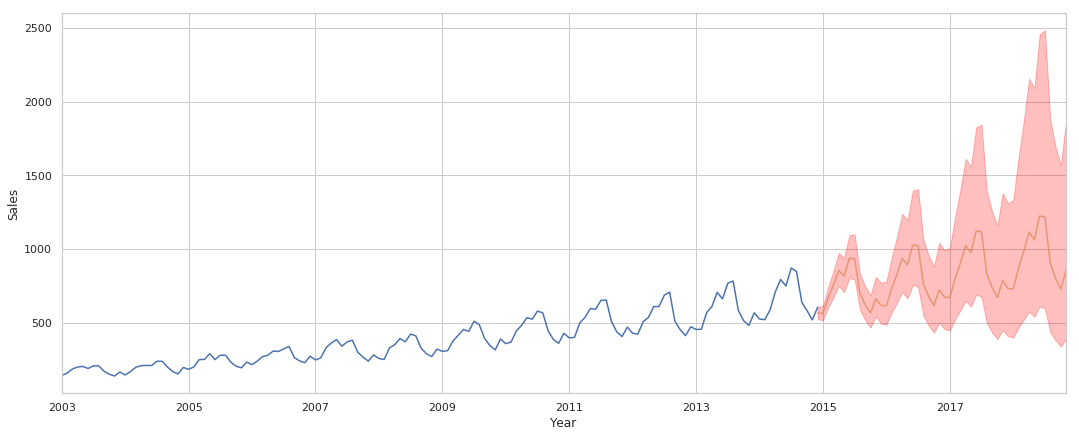

In [51]:
ax = trac_sales.plot(label='Observed', figsize=(18, 7))
forecast_48_df['Forecast'].plot(ax=ax, label='Forecasted', alpha=0.7)
ax.fill_between(forecast_48_df.index, forecast_48_df['Lower_Forecast'], forecast_48_df['Upper_Forecast'], color='red', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Sales')
plt.show()

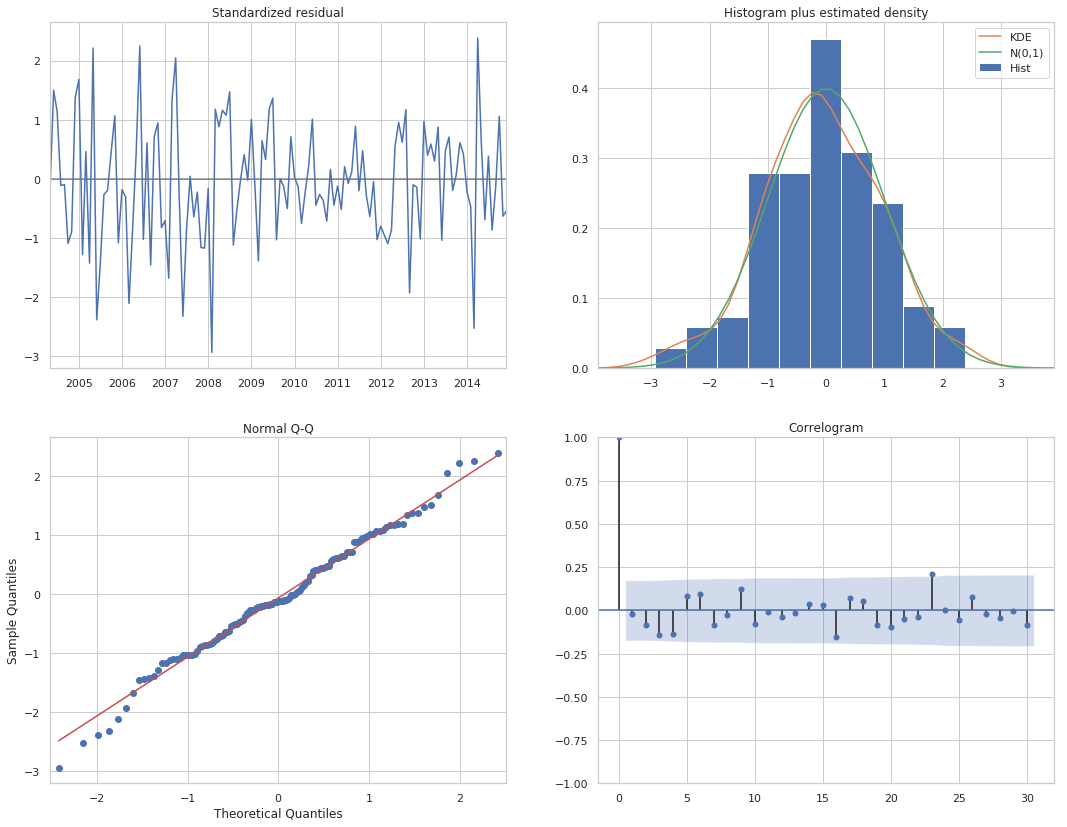

In [52]:
sari.plot_diagnostics(lags=30, figsize=(18,14))
plt.show()

Thank You
* ~ C.Varun ~